# Naive Bayes

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from joblib import dump, load
from sklearn.pipeline import Pipeline

In [47]:
df_train = pd.read_csv('../../data/New dataset/Naive Bayes/train_tweets_Naive_Bayes_new.csv')
df_val = pd.read_csv('../../data/New dataset/Naive Bayes/eval_tweets_Naive_Bayes_new.csv')
df_test = pd.read_csv('../../data/New dataset/Naive Bayes/test_tweets_Naive_Bayes_new.csv')

# Vectorizer Choiche

Initially, we tried two different vectorizer, count vectorizer and Tf-idf vectorizer, to understand if for our problem, one was better than the other.

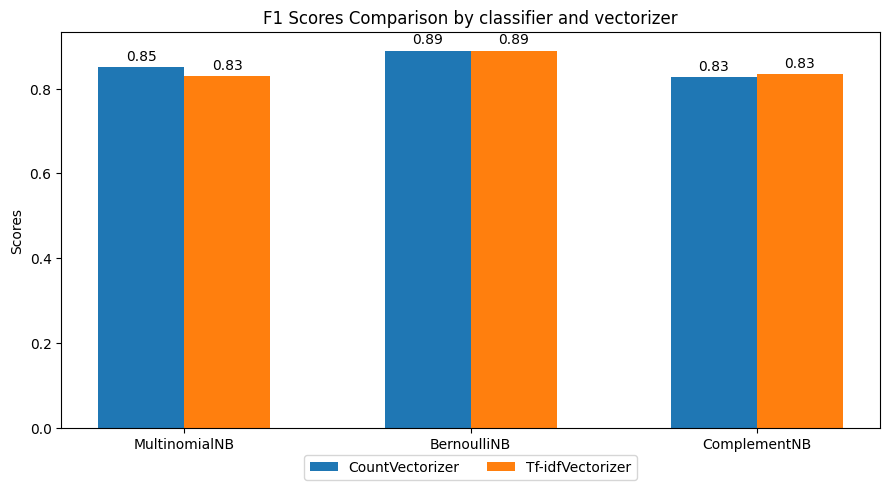

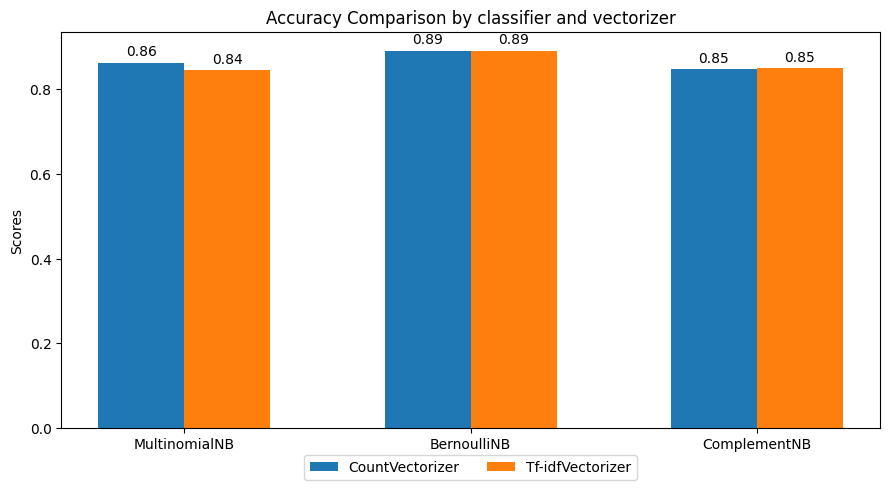

In [10]:
def train_evaluate_models(train, test, vectorizers, classifiers):
    results = {}

    # Extract features and labels
    X_train, y_train = train["tweet_text"], train["cyberbullying_type"]
    X_test, y_test = test["tweet_text"], test["cyberbullying_type"]

    for classifier_name, classifier in classifiers.items():
        result_entry = {}
        for vectorizer_name, vectorizer in vectorizers.items():
            X_train_transformed = vectorizer.fit_transform(X_train)
            X_test_transformed = vectorizer.transform(X_test)

            # Train classifier
            classifier.fit(X_train_transformed, y_train)

            # Predict on test set
            y_pred = classifier.predict(X_test_transformed)

            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')

            result_entry[vectorizer_name] = (f1, accuracy)

        results[classifier_name] = result_entry

    return results


def plot_evaluation_results(results, title, metric_name):
    classifiers = list(results.keys())
    count_scores = [results[clf]['CountVectorizer'][0 if metric_name == 'F1 Score' else 1] for clf in classifiers]
    tfidf_scores = [results[clf]['TfidfVectorizer'][0 if metric_name == 'F1 Score' else 1] for clf in classifiers]

    x = np.arange(len(classifiers))  # the label locations
    width = 0.3  

    fig, ax = plt.subplots(figsize=(9, 5))
    rects1 = ax.bar(x - width/2, count_scores, width, label='CountVectorizer')
    rects2 = ax.bar(x + width/2, tfidf_scores, width, label='Tf-idfVectorizer')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'{title} by classifier and vectorizer')
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Function to add labels with truncated values
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    fig.tight_layout()

    plt.show()


vectorizers = {
    'CountVectorizer': CountVectorizer(min_df=3),
    'TfidfVectorizer': TfidfVectorizer(min_df=3)
}
classifiers = {
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB(),
    'ComplementNB': ComplementNB()
}

results = train_evaluate_models(df_train, df_test, vectorizers, classifiers)
plot_evaluation_results(results, 'F1 Scores Comparison', 'F1 Score')
plot_evaluation_results(results, 'Accuracy Comparison', 'Accuracy')


By plotting both accuracy and F1 scores we noticed that there were no significant differencies in choosing one over the other. The counter vectorizer performed slightly better, so we decided to use this one.

In [11]:
def vectorize(train, test, val, binary=False):
    vectorizer = CountVectorizer(min_df=3)
    
    # Extract features and labels
    X_train, y_train = train["tweet_text"], train["cyberbullying_type"]
    X_val, y_val = val["tweet_text"], val["cyberbullying_type"]
    X_test, y_test = test["tweet_text"], test["cyberbullying_type"]

    if binary:
        y_train = y_train.astype('int')
        y_val = y_val.astype('int')
        y_test = y_test.astype('int')

    # Vectorize text data
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test, vectorizer

# Usage of the vectorize function
X_train, y_train, X_val, y_val, X_test, y_test, vectorizer = vectorize(df_train, df_test, df_val)


In the following cells we define functions to train and test different Naive Bayes models.

In [12]:
def print_top_words(classifier, vectorizer, class_labels, n=10):
    # Extract the feature names
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        # Get the log probabilities of the features
        top_features = np.argsort(classifier.feature_log_prob_[i])[-n:]
        top_words = [feature_names[j] for j in top_features]
        print(f"Top words for class {class_label}: {', '.join(top_words)}")

In [33]:
def train_evaluate_model2(X_train, y_train, X_val, y_val, vectroizer, classifier, title, model_filename='miglior_modello.joblib'):

    # Feature Selection
    total_features = X_train.shape[1]
    k_values = [int(total_features * pct) for pct in (0.1, 0.2, 0.3, 0.5, 0.7, 1)]
    
    best_accuracy = 0
    best_k = None
    accuracies = []
    best_k_data = None
    best_selector = None

    for k in k_values:
        # Apply SelectKBest
        selector = SelectKBest(chi2, k=k)
        X_train_k = selector.fit_transform(X_train, y_train)
        X_val_k = selector.transform(X_val)

        # Train classifier
        classifier.fit(X_train_k, y_train)
        
        # Predict on validation set
        y_val_pred = classifier.predict(X_val_k)
        
        # Calculate accuracy on validation set
        accuracy = accuracy_score(y_val, y_val_pred)

        # Store accuracies values for different k to plot them 
        accuracies.append((k, accuracy))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_k_data = X_train_k
            best_selector = selector
    
    # We refit the classifier on the best number of features k we found
    X = best_k_data
    classifier.fit(X, y_train)
    
    print(f'Best model with k={best_k} features:')

    # Plot accuracies for different k values
    k_values, acc_values = zip(*accuracies)
    plt.plot(k_values, acc_values, marker='o')
    plt.title(f'{title} - Accuracy vs Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.show()

    # Save best model and selector (this is commented because the best model has already been saved)
    dump((classifier, best_selector, vectorizer), model_filename)


In [19]:
def test_model(X_test, y_test, best_selector, best_classifier, vectorizer, classes = None):
    if classes is None:
        classes = ['not cyberbullying', 'cyberbullying']  # Default labels for binary classification
        labels = [0,1]
    else:
        labels = classes

    X_test_k = best_selector.transform(X_test)
    y_pred_test = best_classifier.predict(X_test_k)

    print(classification_report(y_test, y_pred_test))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_test, labels=labels)
    
    best_k = best_selector.k
    
    # Plot confusion matrix with title
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(f'{title} (k={best_k} features)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Print top words for each class
    print_top_words(best_classifier, vectorizer, classes, n=10)

# Get the sorted list of unique class labels, we will need it for the graph
classes = sorted(df_train['cyberbullying_type'].unique())

# Multiclass Naive Bayes Classifier

Initially, we train 3 different types od Naive Bayes models for the multiclass problem. 

## Multinomial Naive Bayes Model
- Designed for discrete count-based data (e.g., text data represented by word frequency).	
- Features are counts of occurrences in different classes.
- Text classification, document categorization, sentiment analysis.

Best model with k=8078 features:


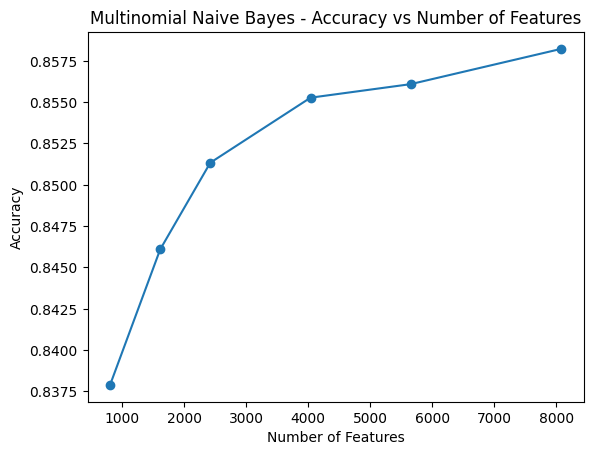

In [20]:
# Train the model
classifier = MultinomialNB()
title = 'Multinomial Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'best_model_MNB.joblib')

                   precision    recall  f1-score   support

              age       0.83      0.97      0.90      1568
        ethnicity       0.89      0.93      0.91      1502
           gender       0.90      0.82      0.86      1497
not_cyberbullying       0.80      0.58      0.67      1338
         religion       0.86      0.97      0.91      1614

         accuracy                           0.86      7519
        macro avg       0.86      0.85      0.85      7519
     weighted avg       0.86      0.86      0.86      7519



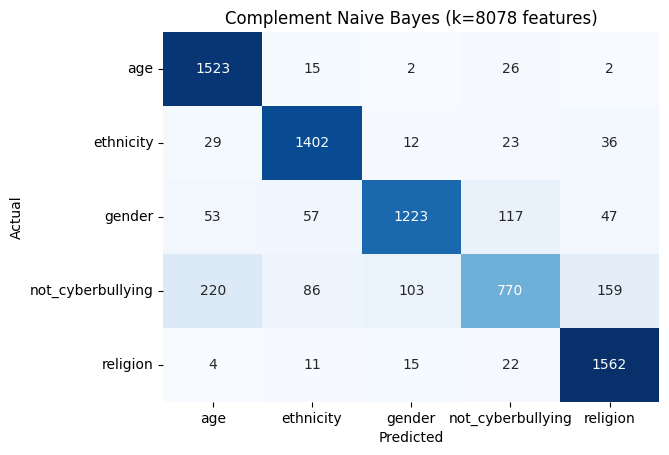

Top words for class age: would, people, go, one, get, like, girl, high, school, bully
Top words for class ethnicity: one, say, people, call, white, as, black, dumb, nigger, fuck
Top words for class gender: like, female, people, woman, bitch, call, make, gay, rape, joke
Top words for class not_cyberbullying: think, kat, know, people, would, like, school, go, get, bully
Top words for class religion: support, islamic, people, woman, like, right, terrorist, christian, idiot, muslim


In [25]:
# Test the model
best_classifier, best_selector, vectorizer = load('Models/Naive Bayes/best_model_MNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer, classes)

## Complement Naive Bayes Model
- Designed for categorical data with imbalanced classes.
- Features are represented by attribute frequencies in documents.
- Useful when classes are imbalanced and training data is limited.
- Used in text classification, document categorization, and reviews analysis applications.

Best model with k=8078 features:


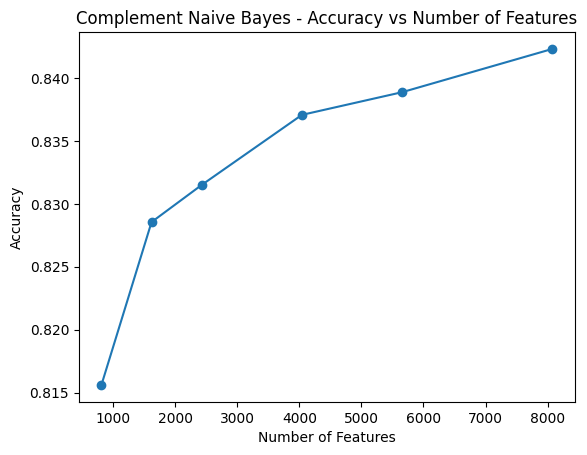

In [22]:
# Train the model
classifier = ComplementNB()
title = 'Complement Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'best_model_CNB.joblib')

                   precision    recall  f1-score   support

              age       0.79      0.99      0.88      1568
        ethnicity       0.88      0.95      0.91      1502
           gender       0.91      0.81      0.86      1497
not_cyberbullying       0.84      0.44      0.58      1338
         religion       0.84      0.98      0.90      1614

         accuracy                           0.85      7519
        macro avg       0.85      0.84      0.83      7519
     weighted avg       0.85      0.85      0.83      7519



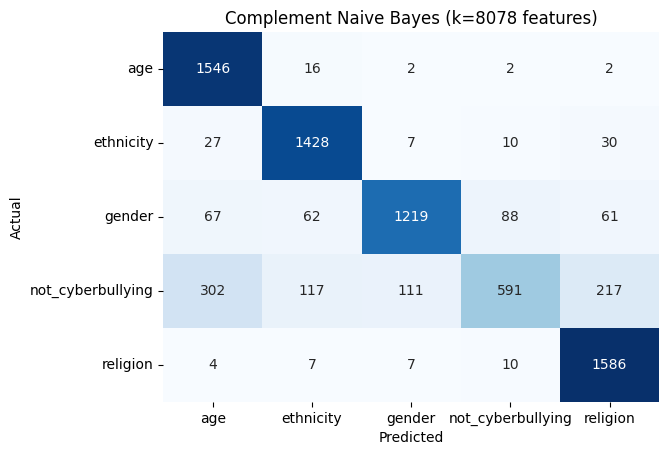

Top words for class age: nov, prefect, introvert, dir, uwu, curve, assistant, stall, middlehigh, volleyball
Top words for class ethnicity: mofo, nb, negros, nephilim, nigganigger, niggerbitch, bm, niggerfuck, quadruplet, 00
Top words for class gender: antifeminist, feminazis, murphy, blowup, femme, fems, macfarlane, valenti, tosh, ganda
Top words for class not_cyberbullying: hago, itreallymakesmemad, meninos, esa, escola, ese, eso, meninas, hacer, fritter
Top words for class religion: designate, somalian, ramadan, somalia, rake, hijbul, partition, thm, mandir, placard


In [26]:
# Test the model
best_classifier, best_selector, vectorizer = load('Models/Naive Bayes/best_model_CNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer, classes)

## Bernoulli Naive Bayes Model

- Designed for discrete count-based data, such as text data represented by word frequency.
- Features are counts of occurrences in different classes.
- Commonly used in text classification, document categorization, and sentiment analysis tasks.

Best model with k=807 features:


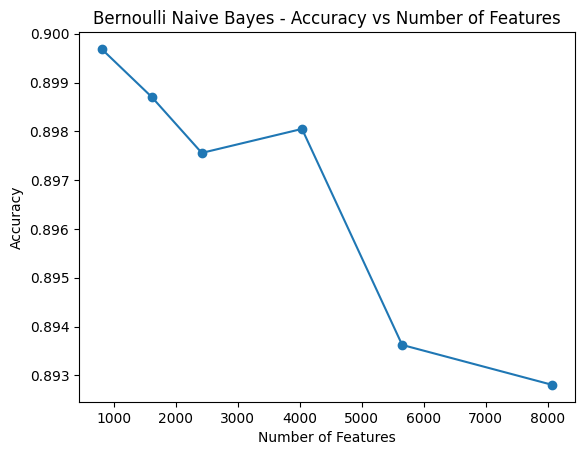

In [34]:
# Train the model
classifier = BernoulliNB()
title = 'Bernoulli Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'best_model_BNB.joblib')

                   precision    recall  f1-score   support

              age       0.98      0.96      0.97      1568
        ethnicity       0.96      0.92      0.94      1502
           gender       0.94      0.78      0.85      1497
not_cyberbullying       0.70      0.89      0.79      1338
         religion       0.93      0.93      0.93      1614

         accuracy                           0.90      7519
        macro avg       0.90      0.90      0.90      7519
     weighted avg       0.91      0.90      0.90      7519



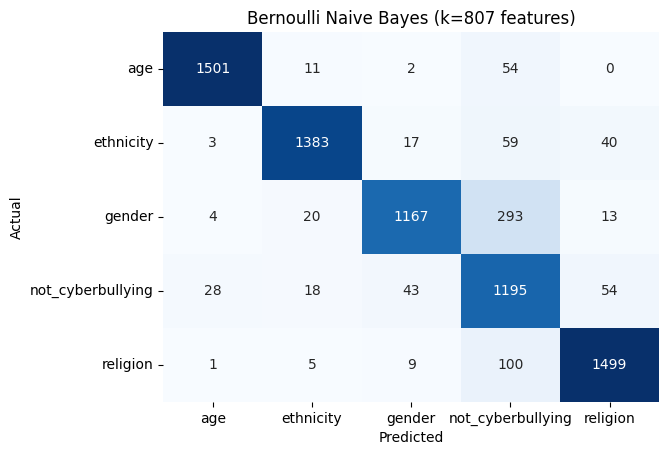

Top words for class age: becuz, army, appropriate, africanamerican, afford, and, afghanistan, ainda, autism, 37
Top words for class ethnicity: appropriate, application, army, 3k, beating, 24, 1997, access, advantage, apparently
Top words for class gender: army, award, addict, 2200, become, 3k, anna, affair, aswell, alumnus
Top words for class not_cyberbullying: amir, barbarity, amd, army, becuz, and, autism, africanamerican, afford, 37
Top words for class religion: ballot, become, alone, army, and, barbarian, attribute, 50, alex, ap


In [35]:
# Test the model
best_classifier, best_selector, vectorizer = load('Models/Naive Bayes/best_model_BNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer, classes)

# Binary Naive Bayes Classifier

Then, we tried also with the binary problem.

In [51]:
df_train = pd.read_csv('../../data/New dataset/Naive Bayes/train_tweets_Naive_Bayes_new_binary.csv')
df_val = pd.read_csv('../../data/New dataset/Naive Bayes/eval_tweets_Naive_Bayes_new_binary.csv')
df_test = pd.read_csv('../../data/New dataset/Naive Bayes/test_tweets_Naive_Bayes_new_binary.csv')

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

X_train, y_train, X_val, y_val, X_test, y_test, vectorizerr = vectorize(df_train, df_test, df_val, binary = True)

## Multinomial Naive Bayes Model

Best model with k=2858 features:


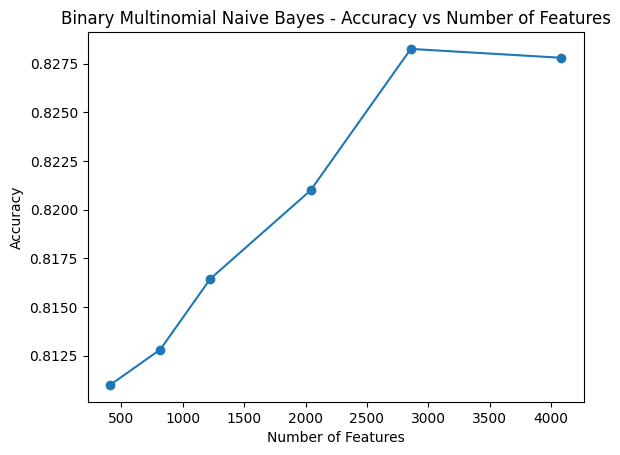

In [52]:
# Train the model
classifier = MultinomialNB()
title = 'Binary Multinomial Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'BIN_best_model_MNB.joblib')

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1338
           1       0.75      0.91      0.83      1336

    accuracy                           0.81      2674
   macro avg       0.82      0.81      0.81      2674
weighted avg       0.82      0.81      0.81      2674



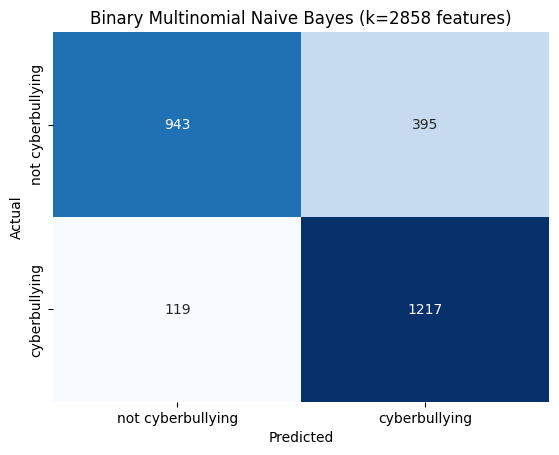

Top words for class not cyberbullying: object, pill, host, gather, favor, loser, discourage, dig, forget, bay
Top words for class cyberbullying: devs, improve, eastern, forget, come, higher, falando, depression, bay, loser


In [53]:
# Test the model
best_classifier, best_selector, vectorizer= load('Models/Naive Bayes/BIN_best_model_MNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer)

## Complement Naive Bayes Model

Best model with k=2858 features:


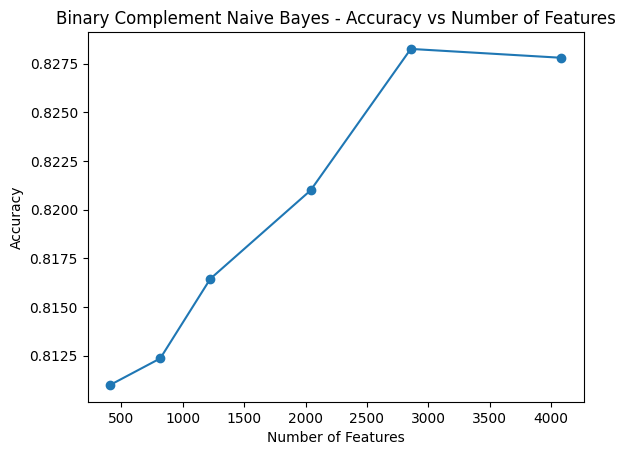

In [54]:
# Train the model
classifier = ComplementNB()
title = 'Binary Complement Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'BIN_best_model_CNB.joblib')

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1338
           1       0.75      0.91      0.83      1336

    accuracy                           0.81      2674
   macro avg       0.82      0.81      0.81      2674
weighted avg       0.82      0.81      0.81      2674



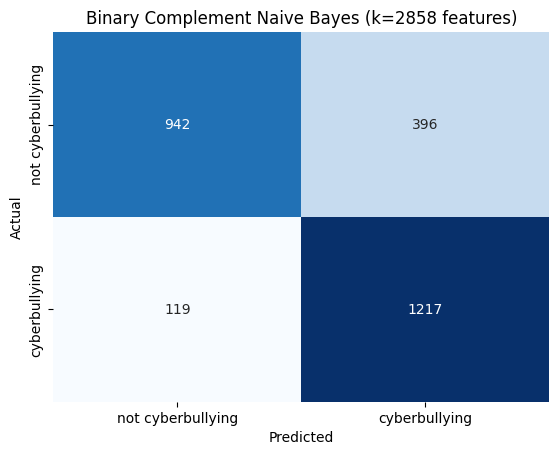

Top words for class not cyberbullying: loving, def, dean, deal, de, day, daughter, data, defensive, conversion
Top words for class cyberbullying: except, ew, evil, everywhere, everytime, everything, everyone, every, fruit, problematic


In [55]:
# Test the model
best_classifier, best_selector, vectorizer= load('Models/Naive Bayes/BIN_best_model_CNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer)

## Bernoulli Naive Bayes Model

Best model with k=1224 features:


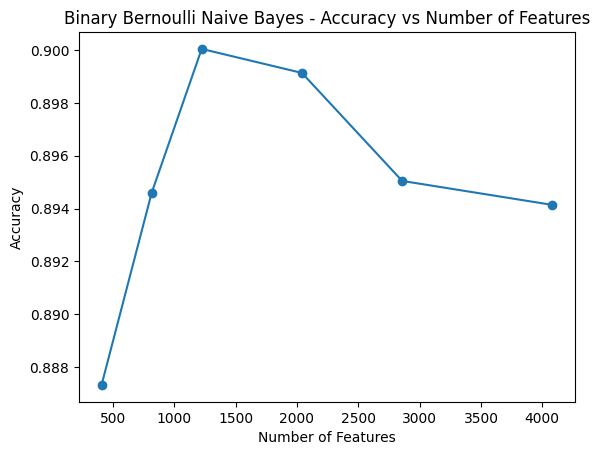

In [56]:
# Train the model
classifier = BernoulliNB()
title = 'Binary Bernoulli Naive Bayes'
train_evaluate_model2(X_train, y_train, X_val, y_val, vectorizer, classifier, title, 'BIN_best_model_BNB.joblib')

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1338
           1       0.93      0.82      0.87      1336

    accuracy                           0.88      2674
   macro avg       0.89      0.88      0.88      2674
weighted avg       0.89      0.88      0.88      2674



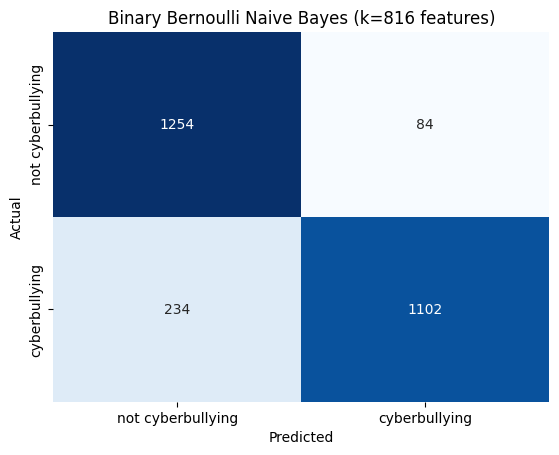

Top words for class not cyberbullying: clear, comp, bomb, believe, bang, case, arrive, armstrong, beat, accusation
Top words for class cyberbullying: army, butter, area, asshole, beat, americans, boat, appropriate, accusation, case


In [57]:
# Test the model
best_classifier, best_selector, vectorizer = load('Models/Naive Bayes/BIN_best_model_BNB.joblib')
test_model(X_test, y_test, best_selector, best_classifier, vectorizer)